In [1]:
import numpy as np
import pandas as pd
import librosa
import sys
import glob
import os
from keras.models import load_model
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Global Variables

In [9]:
root = 'ToiletSoundSet'
validate_folder_path = root + '/validate_data'
predict_folder_path = 'predict'
model_path = 'models/toilet_sound_cnn_71.h5'
class_labels = [
    "toilet_flush",
    "shower",
    "door",
    "broken_glass",
    "clapping",
    "dog_bark"
]
target_wav_duration = 2.97
wav_data_shape_x = 128
wav_data_shape_y = 128

### Common Functions

In [10]:
def extract_feature(file_path):
    y, sr = librosa.load(file_path, duration=target_wav_duration)
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (wav_data_shape_x, wav_data_shape_y):
        return None, None
    return ps, sr

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [11]:
model = load_model(model_path)
true_labels = []
predict_labels = []
for root, _, files in os.walk(validate_folder_path):
    for file in files:
        file_name, file_extension = os.path.splitext(file)        
        if file_extension != '.wav': continue
        file_path = os.path.join(root, file)
        ps, sr = extract_feature(file_path)
        if sr == None:
            continue
        class_label = int(file_name.split('-')[1])
        true_labels.append(class_label)
        predict_ds = []
        predict_ds.append(ps)
        predict_ds = np.array([data.reshape( (128, 128, 1) ) for data in predict_ds])
        result = model.predict_classes(predict_ds)
        predict_labels.append(result[0])

Normalized confusion matrix
[[0.93 0.   0.   0.   0.07 0.  ]
 [0.1  0.8  0.03 0.   0.03 0.03]
 [0.17 0.24 0.55 0.03 0.   0.  ]
 [0.04 0.11 0.07 0.7  0.07 0.  ]
 [0.04 0.11 0.04 0.07 0.71 0.04]
 [0.07 0.   0.1  0.07 0.17 0.6 ]]


<Figure size 432x288 with 0 Axes>

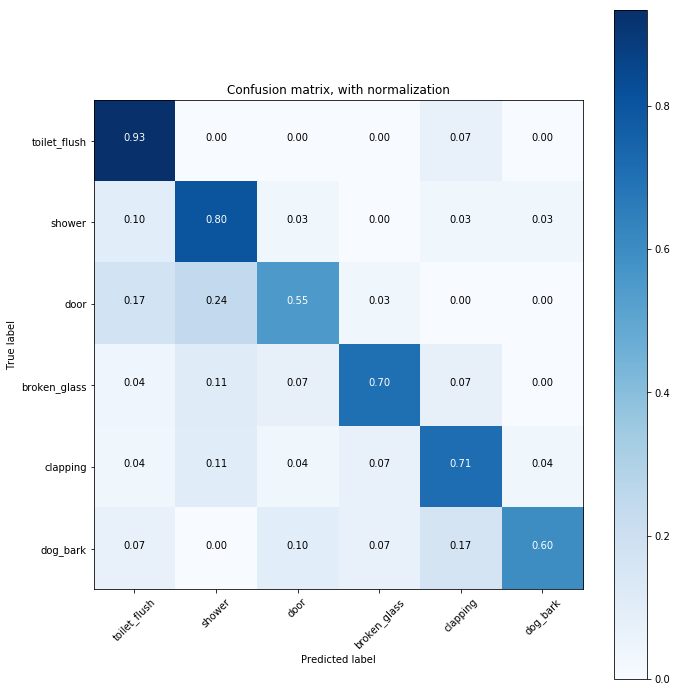

In [12]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(true_labels, predict_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_labels,
                      normalize=True,
                      title='Confusion matrix, with normalization')


In [13]:
for root, _, files in os.walk(predict_folder_path):
    for file in files:
        file_name, file_extension = os.path.splitext(file)        
        if file_extension != '.wav': continue
        file_path = os.path.join(root, file)
        ps, sr = extract_feature(file_path)
        if sr == None:
            continue        
        data_set = []
        data_set.append(ps)
        data_set = np.array([data.reshape( (128, 128, 1) ) for data in data_set])
        predictions = model.predict(data_set)[0]
        print('============= Predict wav {} ============='.format(file_name))
        for index, predict in enumerate(predictions):
            result = '{0} {1:.2f}%'.format(class_labels[index], predict * 100)
            print(result)

============= Predict wav 24965 =============
toilet_flush 0.00%
shower 0.00%
door 0.00%
broken_glass 0.00%
clapping 0.00%
dog_bark 100.00%
============= Predict wav 104327 =============
toilet_flush 27.13%
shower 8.59%
door 12.62%
broken_glass 7.61%
clapping 22.14%
dog_bark 21.92%
